In [197]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit

## Read bidding log for advertiser 2821

In [2]:
df_2821 = pd.read_csv("2821/train.log.txt", delimiter="\t")
df_2821.head()

,click,weekday,hour,bidid,timestamp,logtype,ipinyouid,useragent,IP,region,...,slotheight,slotvisibility,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,usertag
0,0,1,19,49b5a58c3a3c39c32ba5a36f70a3daa5,20131021192300738,1,C4NDR12~1B,windows_ie,222.218.230.*,238,...,250,FirstView,Na,0,10722,294,201,NaN,2821,10063
1,0,1,21,a10d601d8d23a36921ce597e0fb327f1,20131021210002124,1,C8INvJAR60,windows_ie,218.107.8.*,216,...,90,FirstView,Na,30,10717,294,36,NaN,2821,"10048,16751,14273,10117,10083,13776,10110,1340..."
2,0,1,19,6dcedee2836180e18dfd4663930839be,20131021193302410,1,CAMK525fdzC,windows_ie,123.178.216.*,27,...,90,FirstView,Na,0,10717,294,268,NaN,2821,"11278,10684,11576,11632,10083,10006,10110,1006..."
3,0,1,21,1cb9ff52202db973f928f06be5c8ab36,20131021213601978,1,CAMLZkA3d4U,windows_chrome,113.123.67.*,146,...,90,Na,Na,20,10734,294,80,NaN,2821,"10057,10067,10059,14273,10077,10075,10083,1386..."
4,0,1,21,447c9c9a83cef3a3f198f7ffd63ed256,20131021214301540,1,CAQ6Ja1_bT7,windows_chrome,123.164.44.*,65,...,90,Na,Na,20,10734,294,160,NaN,2821,"10140,10067,10059,10083,10129,10024,10006,1011..."


### Inspect bid price

Price unit: RMB/CPM

`CPM`: cost per thousand impressions

prices are linearly scaled for confidentiality

In [88]:
df_2821['bidprice'].unique()

array([294, 277])

> This advertiser only bids on two different prices: 294 or 277

### Bid price by ad exchange

In [6]:
df_2821[df_2821['bidprice'] == 277]['adexchange'].unique()

array([2])

In [7]:
df_2821[df_2821['bidprice'] == 294]['adexchange'].unique()

array([1, 4, 3])

>This advertiser always send bid price of 277 for ad exchange 2 (Google), and 294 for 1(Alibaba), 3(Tencent), 4(Baidu)

## Distribution of payprice, by ad exchange
**Ad Exchange**

- 1 - Tanx (Alibaba)
- 2 - Adx (Google DoubleClick AdX)
- 3 - Tencent (Tencent)
- 4 - Baidu(Baidu)
- 5 - Youku(Youku) - N/A for this advertiser
- 6 - Amx(Google Mobile) - N/A for this advertiser

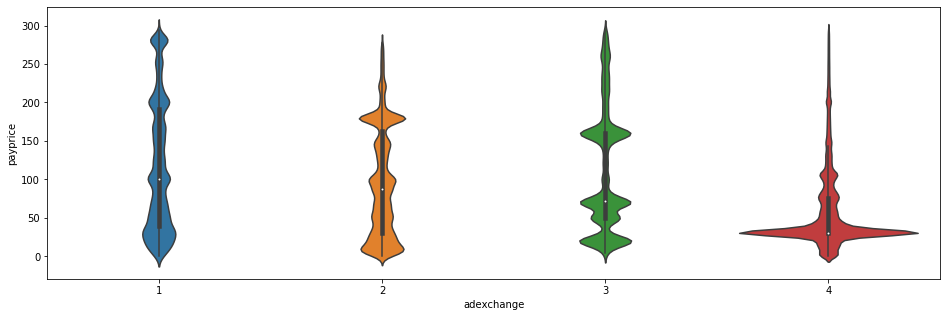

In [100]:
plt.subplots(figsize=(16,5))
ax = sns.violinplot(x="adexchange", y="payprice", data=df_2821)
plt.show()

## Explore bidding on Ad Exchange 2 (Google Adx)

In [73]:
adx = df_2821['adexchange'] == 2
# sort by payprice
sorted_adx = df_2821[adx].sort_values(by=['payprice'])
sorted_adx.head()

,click,weekday,hour,bidid,timestamp,logtype,ipinyouid,useragent,IP,region,...,slotheight,slotvisibility,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,usertag
1033018,0,2,15,cfdd7b8f6421720be4d30406fd8c4ddc,20131022151956815,1,DAMFJtCkxcK,windows_ie,60.177.27.*,94,...,600,OtherView,Na,5,10733,277,0,NaN,2821,NaN
347868,0,1,22,785d3b2363839d85c8e943d5eb3d8232,20131021220100316,1,D75KRK3EyeA,windows_chrome,112.98.22.*,65,...,90,OtherView,Na,4,10719,277,4,NaN,2821,"10076,10075,10129,10024,10006,10110,10120,10145"
599584,0,1,22,d54815d3e83c75ec47c347ee3b73d43d,20131021224100493,1,DALMe07izx3,windows_chrome,183.167.144.*,106,...,280,OtherView,Na,4,10720,277,4,NaN,2821,NaN
67879,0,1,22,75ea8b6d12a6cc5235c846430a37d233,20131021221420665,1,DALMEKAPw9k,windows_chrome,221.130.13.*,80,...,250,OtherView,Na,4,10722,277,4,NaN,2821,NaN
1318864,0,3,18,c35be14736d86bcb95d48293aa81ea80,20131023180600353,1,DANGI85SyZp,windows_chrome,113.96.239.*,216,...,250,OtherView,Na,4,10722,277,4,NaN,2821,NaN


### Count number of bids by payprice

In [83]:
counts = sorted_adx['payprice'].reset_index()
counts = counts.groupby(by="payprice").count()[['index']]
counts.rename(columns={'index':'count'}, inplace=True)
counts.head(10)

,count
payprice,
0,1
4,916
5,15396
6,2397
7,2709
8,3182
9,2779
10,3170
11,3164


### Calculate cumulaltive stats

In [84]:
counts['cumsum_count'] = counts['count'].cumsum()
counts['bracket_cost'] = counts['count'] * counts.index 
counts['cumsum_cost'] = counts['bracket_cost'].cumsum()
counts['cummean_cost'] = counts['cumsum_cost'] / counts['cumsum_count']
counts.head(10)

,count,cumsum_count,bracket_cost,cumsum_cost,cummean_cost
payprice,,,,,
0,1,1,0,0,0.000000
4,916,917,3664,3664,3.995638
5,15396,16313,76980,80644,4.943542
6,2397,18710,14382,95026,5.078888
7,2709,21419,18963,113989,5.321864
8,3182,24601,25456,139445,5.668266
9,2779,27380,25011,164456,6.006428
10,3170,30550,31700,196156,6.420818
11,3164,33714,34804,230960,6.850567


# Plots

## Cumulative Impressions as bid price increases
$KPI_i(x_i)$ 

where KPI = Impressions, i = 2(Google adx)

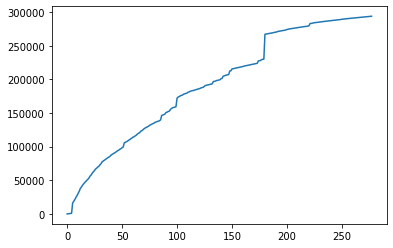

In [78]:
plt.plot(counts['cumsum_count'])
plt.show()

## Cumulative Cost as bid price increases
$KPI_i(x_i) * AP_i(x_i)$ 

where KPI = Impressions, i = 2(Google adx)

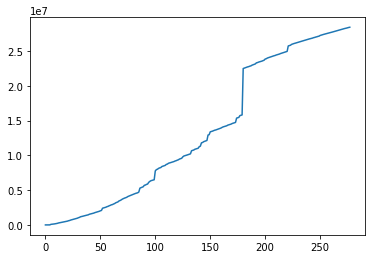

In [79]:
plt.plot(counts['cumsum_cost'])
plt.show()

## Cumulative Average pay price as bid price increases
$AP_i(x_i)$ 

where KPI = Impressions, i = 2(Google adx)

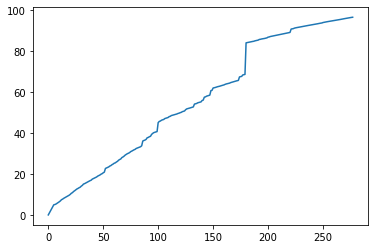

In [80]:
plt.plot(counts['cummean_cost'])
plt.show()

## Model the budget_i as decision variable directly

$\Sigma_i y_i \le Budget$

where $y_i$ is the total budget allocated for website i

In [163]:
y = sorted_adx[['payprice']].cumsum()
y["impressions"] = np.arange(len(y))

In [164]:
y.columns = ['y', 'impressions']

## Scatter Plot

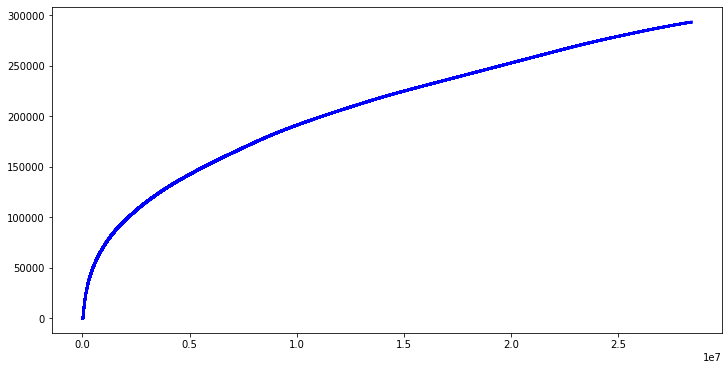

In [178]:
plt.subplots(figsize=(12,6))
plt.scatter(y['y'], y['impressions'], marker='.', c='b', alpha=0.002)
plt.show()

## Fit curve 1

/Users/zhongqihua/anaconda3/envs/bio/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


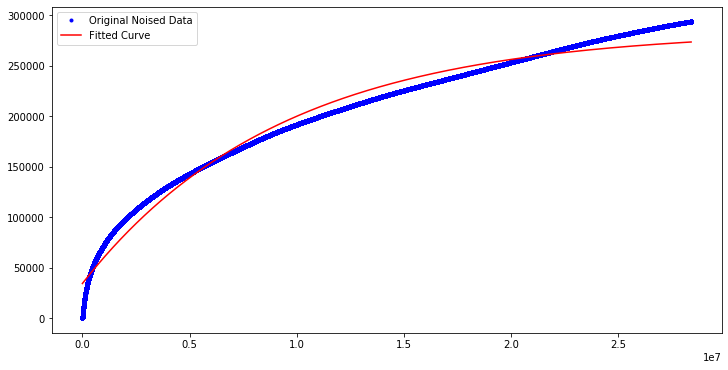

In [184]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c


popt, pcov = curve_fit(func, y['y'], y['impressions'])

plt.subplots(figsize=(12,6))
plt.plot(y['y'], y['impressions'], 'b.', label="Original Noised Data")
plt.plot(y['y'], func(y['y'], *popt), 'r-', label="Fitted Curve")
plt.legend()
plt.show()

## Fit curve 2

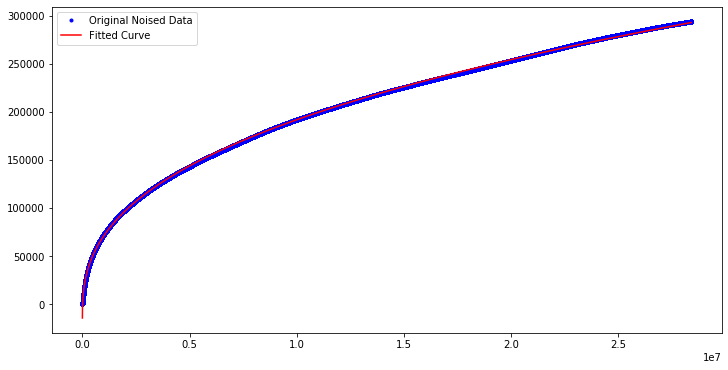

In [195]:
def func(x, a, b, c, d):
    return a * np.power(b * x/1000, c) + d


popt, pcov = curve_fit(func, y['y'], y['impressions'])

plt.subplots(figsize=(12,6))
plt.plot(y['y'], y['impressions'], 'b.', label="Original Noised Data")
plt.plot(y['y'], func(y['y'], *popt), 'r-', label="Fitted Curve")
plt.legend()
plt.show()

In [196]:
popt

array([ 6.54301602e+02,  3.44588487e+02,  3.82194499e-01, -1.45236276e+04])